In [1]:
import os
from joblib import dump
from pathlib import Path

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import numpy as np

import time
from scipy.stats import loguniform, randint
from yellowbrick.model_selection import RFECV
from scipy.stats import loguniform, randint
from sklearn.model_selection import RandomizedSearchCV
import warnings

In [2]:
# import cuml
# from cuml.linear_model import LogisticRegression as cuLogisticRegression
# from sklearn.model_selection import RandomizedSearchCV
# import cudf

In [3]:
# Set up directory
os.chdir("/home/siti/Downloads/New Modelling")

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('AE_Synthetic_Data_Final_V02.csv')

In [4]:
print(df["LOS_Category"].value_counts())

Short stay    11942983
Long stay       779233
Name: LOS_Category, dtype: int64


In [5]:
results_folder = Path("DT_folder/SMOTETOMEK/Model 1")
results_folder.mkdir(parents=True, exist_ok=True) 

In [6]:
# Convert object types to category
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [7]:
data = df.copy()
# Define the features and target
feature_cols = data.columns[data.columns != 'LOS_Category']
X = data[feature_cols]
y = data['LOS_Category']


# Step 1: Map the Outcome Variable

In [8]:
y = y.map({'Short stay': 1, 'Long stay': 0})

In [9]:
print(y.value_counts())

1    11942983
0      779233
Name: LOS_Category, dtype: int64


# Step 2: Split Data

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

**Overall Proportions:**

- **Test set**: 15% of the original dataset
- **Validation set**: 0.1765 * 0.85 = 0.15 or 15% of the original dataset
- **Training set**: 1−0.15−0.15 = 0.7 or 70% of the original dataset

So, by using this two-step splitting, we've achieved a 70-15-15 split for the training, validation, and test datasets, respectively.

# Step 3: One-Hot Encoding 

In [11]:
# Your nominal columns
nominal_columns = ['Sex', 'AE_Arrival_Mode', 'ICD10_Chapter_Code', 'TFC']

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=nominal_columns, drop_first=True)
X_val = pd.get_dummies(X_val, columns=nominal_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nominal_columns, drop_first=True)

# Get all columns in X_train after one-hot encoding
all_columns = X_train.columns

# Ensure X_val has the same columns as X_train
for col in all_columns:
    if col not in X_val.columns:
        X_val[col] = 0

# Ensure X_test has the same columns as X_train
for col in all_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Reorder columns in X_val and X_test to match X_train's order
X_val = X_val[all_columns]
X_test = X_test[all_columns]


# Step 4: Ordinal Encoding

In [12]:
orders = {
    'IMD_Category': ['Most deprived 20%', '20% - 40%', '40 - 60%', '60% - 80%', 'Least deprived 20%'],
    'Age_Band': ['01-17', '18-24', '25-44', '45-64', '65-84', '85+'],
    'AE_Arrive_HourOfDay': ['01-04','05-08','09-12','13-16','17-20','21-24'],
    'AE_HRG': ['Nothing', 'Low', 'Medium', 'High']
}

# Loop through each column and its respective order to encode
for col, order in orders.items():
    ordinal_encoder = OrdinalEncoder(categories=[order])
    X_train[col] = ordinal_encoder.fit_transform(X_train[[col]])
    X_val[col] = ordinal_encoder.transform(X_val[[col]])
    X_test[col] = ordinal_encoder.transform(X_test[[col]])

# Step 5: Oversampling with SMOTETOMEK

In [13]:
# Load the oversampled data from the CSV file
df_loaded = pd.read_csv('model1_smotetomek_oversampled_data.csv')

# Separate the features and target variable
X_train_resampled = df_loaded.drop('LOS_Category', axis=1)
y_train_resampled = df_loaded['LOS_Category']

In [14]:
proportions = y_train_resampled.value_counts(normalize=True)
print(proportions)

counts = y_train_resampled.value_counts(normalize=False)
print(counts)

1    0.5
0    0.5
Name: LOS_Category, dtype: float64
1    8358604
0    8358604
Name: LOS_Category, dtype: int64


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# Use only 10% of the data for hyperparameter tuning using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, subset_index in sss.split(X_train_resampled, y_train_resampled):
    X_train_subset = X_train_resampled.iloc[subset_index]
    y_train_subset = y_train_resampled.iloc[subset_index]
    
# Standardize the subset
scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)
X_train_subset_scaled = scaler.fit_transform(X_train_subset)

In [16]:

counts = y_train_subset.value_counts(normalize=False)
print(counts)

0    835861
1    835860
Name: LOS_Category, dtype: int64


# Step 6: Standardize Dataset

In [17]:
# Scale the rest of the data using the subset's statistics
X_train_scaled = scaler.transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 7: RFECV

Perform RFECV on the training set (not including the validation set).

RFECV took 363.69 seconds.


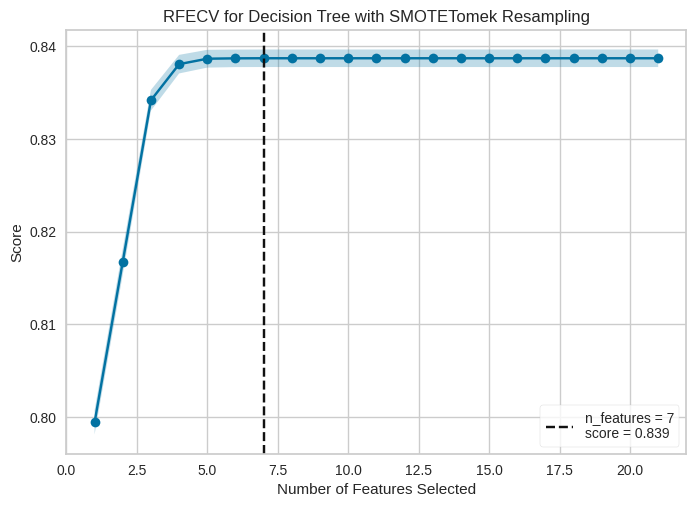

In [18]:
from yellowbrick.model_selection import RFECV
import xgboost as xgb


# Record the start time
start_time = time.time()

# Initialize the Decision Tree estimator using XGBoost
estimator = xgb.XGBClassifier(
    objective='binary:logistic',   
    booster='gbtree',
    n_estimators=1,
    tree_method='hist',
    max_depth=6,
    nthread=7,
    random_state=42
)

plt_title = "RFECV for Decision Tree with SMOTETomek Resampling"

# Use RFECV from Yellowbrick with the settings
visualizer = RFECV(estimator, step=1, cv=5, title=plt_title, scoring='roc_auc')

# Assuming X_train_subset_scaled has been pre-scaled. If not, scale it first.
visualizer.fit(X_train_subset_scaled, y_train_subset)

# Show the visualizer
visualizer.show(outpath= results_folder / "RFECV.png")

# Record the end time
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"RFECV took {duration:.2f} seconds.")

In [19]:
# Print the features selected by RFECV
feature_names = X_train.columns

# Map the selected features to the original column names
selected_features = [feature for mask, feature in zip(visualizer.support_, feature_names) if mask]

print("Selected Features:", selected_features)

Selected Features: ['Age_Band', 'AE_Time_Mins', 'ICD10_Chapter_Code_XIV', 'ICD10_Chapter_Code_XIX', 'ICD10_Chapter_Code_XVIII', 'TFC_180', 'TFC_420']


# Step 8: Hyperparameter Tuning with Randomized Search CV

After feature selection, use RandomizedSearchCV for hyperparameter tuning on the training set. The cross-validation within RandomizedSearchCV uses multiple train-validation splits of the training data.

Use only 10% percent of the training set to perform hyperparameter tuning due to insuffient CPU and GPU resources. The training set is very high after oversampling.

In [20]:

# Extract columns from the scaled and resampled training set using the list of selected features
selected_feature_indices = [X_train.columns.get_loc(feature) for feature in selected_features]
X_train_selected_scaled = X_train_scaled[:, selected_feature_indices]



In [21]:
from sklearn.tree import DecisionTreeClassifier
# Filter X_train_subset_scaled with the best features
X_train_selected_subset_scaled = X_train_subset_scaled[:, selected_feature_indices]

# Define the hyperparameter grid for DecisionTree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.01, 0.1, 0.2, 0.3]
}

# Record the start time
start_time = time.time()

clf_dt = DecisionTreeClassifier(random_state=42)

# Use RandomizedSearchCV to find the best hyperparameters for DecisionTree
random_search = RandomizedSearchCV(
    clf_dt, param_distributions=param_grid_dt, n_iter=50, scoring='roc_auc', n_jobs=7, cv=5, random_state=42, verbose = True)

random_search.fit(X_train_selected_subset_scaled, y_train_subset)

# Save the cv_results_ to a DataFrame and then to a CSV file
cv_results_df = pd.DataFrame(random_search.cv_results_)
cv_results_df.to_csv(results_folder /'cv_results.csv', index=False)

# Print results
print("Best parameters for DecisionTree:", random_search.best_params_)
print("Best ROC-AUC score for DecisionTree:", random_search.best_score_)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Hyperparameter tuning for DecisionTree took {duration:.2f} seconds.")

# Save the model
dump(random_search, results_folder / 'random_search_model.joblib')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for DecisionTree: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 40, 'criterion': 'gini', 'ccp_alpha': 0.0}
Best ROC-AUC score for DecisionTree: 0.8597521948328332
Hyperparameter tuning for DecisionTree took 104.96 seconds.


['DT_folder/SMOTETOMEK/Model 1/random_search_model.joblib']

# Step 9: Train the whole dataset with best hyperparameters


In [22]:
# Extracting selected features for validation, and test sets:

X_val_selected_scaled = X_val_scaled[:, selected_feature_indices]
X_test_selected_scaled = X_test_scaled[:, selected_feature_indices]

In [24]:
# Define the best hyperparameters
best_params = random_search.best_params_

# Record the start time
start_time = time.time()

# Train a DT model using the best hyperparameters on the training set
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train_selected_scaled, y_train_resampled)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Training for DT took {duration:.2f} seconds.")


Training for DT took 31.91 seconds.


# Step 10: Predict and Evaluate on Validation Set

In [25]:
# Record the start time
start_time = time.time()

y_val_pred = best_model.predict(X_val_selected_scaled)
y_val_prob = best_model.predict_proba(X_val_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the validation set using multiple metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_prob)  # Note: roc_auc_score uses probability estimates
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

# Print the metrics
print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("ROC-AUC:", val_roc_auc)
print("F1 Score:", val_f1)
print("Precision:", val_precision)
print("Recall:", val_recall)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Validating for DT took {duration:.2f} seconds.")

Validation Metrics:
Accuracy: 0.6902346212062865
ROC-AUC: 0.7499318255897292
F1 Score: 0.8072758945085264
Precision: 0.970410500718245
Recall: 0.6910964550240631
Validating for DT took 1.95 seconds.


# Step 11: Final Model Training and Test Evaluation

Finally, we train on the combined train+validation data and test on the test set.

In [26]:
# Combine the training and validation sets
X_combined = np.concatenate([X_train_selected_scaled, X_val_selected_scaled], axis=0)
y_combined = np.concatenate([y_train_resampled, y_val], axis=0)

# Record the start time
start_time = time.time()

# Train the final model on the combined set
final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_combined, y_combined)

# Record the end time
end_time = time.time()
duration = end_time - start_time

print(f"Training Decision Tree took {duration:.2f} seconds.")

Training Decision Tree took 32.58 seconds.


In [27]:
dump(final_model, results_folder / 'final_model_DT.joblib')

['DT_folder/SMOTETOMEK/Model 1/final_model_DT.joblib']

# Step 12: Predict on test set

In [28]:
# Predict on the test set
y_test_pred = final_model.predict(X_test_selected_scaled)
y_test_prob = final_model.predict_proba(X_test_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the test set using multiple metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the metrics
print("Test Metrics:")
print("Accuracy:", test_accuracy)
print("ROC-AUC:", test_roc_auc)
print("F1 Score:", test_f1)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("Confusion Matrix:")
print(test_conf_matrix)

Test Metrics:
Accuracy: 0.6978881568363593
ROC-AUC: 0.7503537366754824
F1 Score: 0.8132454407048687
Precision: 0.9688442575629876
Recall: 0.7007097052216977
Confusion Matrix:
[[  76518   40367]
 [ 536163 1255285]]


# Step 13: Save the metrics

In [29]:
# Save all metrics in a csv file

metrics = {
    "ROC-AUC Test": test_roc_auc ,
    "Accuracy": test_accuracy,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Confusion Matrix": test_conf_matrix
}

# Convert the metrics to a DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

# Save to CSV
output_path = results_folder / "Model1_Performance_metrics.csv"
metrics_df.to_csv(output_path, index=False)

print(f"Metrics saved to: {output_path}")

Metrics saved to: DT_folder/SMOTETOMEK/Model 1/Model1_Performance_metrics.csv


# ROC-AUC Curve

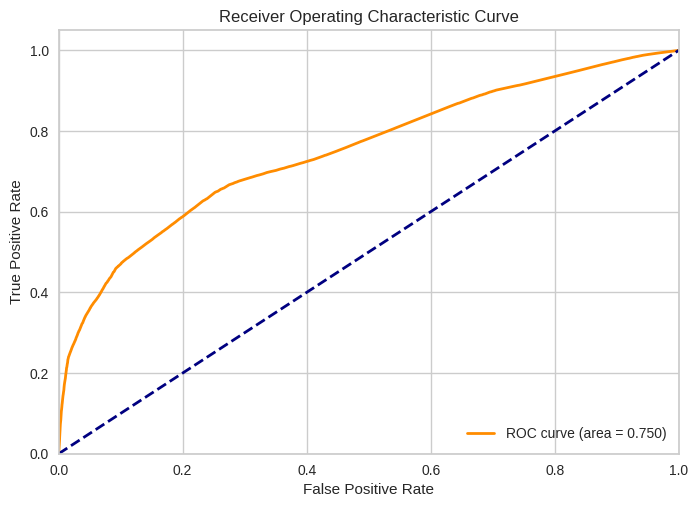

In [30]:
# y_test_prob contains the predicted probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.savefig(results_folder / "roc_auc.png", dpi=300)
plt.show()



# Precision-Recall Curve

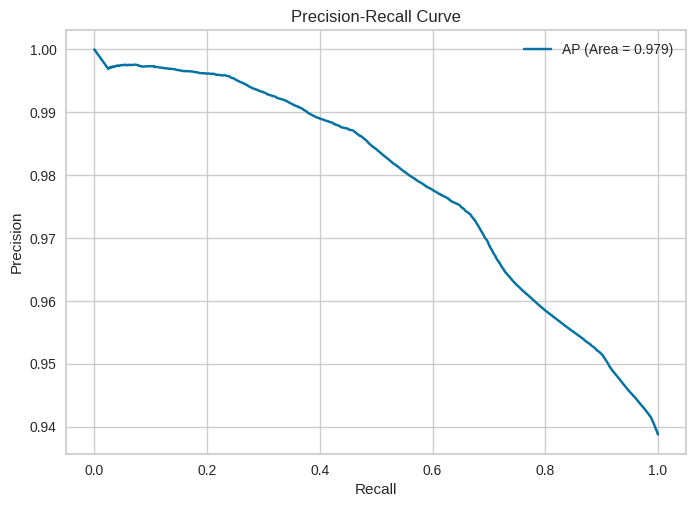

In [31]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
average_precision = average_precision_score(y_test, y_test_prob)

plt.figure()
plt.plot(recall, precision, label='AP (Area = %0.3f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.savefig(results_folder / "precision_recall.png", dpi=300)
plt.show()

# Calculate Error

In [32]:
# Predict on training set
y_combined_pred = final_model.predict(X_combined)
combined_accuracy = accuracy_score(y_combined, y_combined_pred)
combined_error = 1 - combined_accuracy

# Predict on validation set
y_val_pred = final_model.predict(X_val_selected_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_error = 1 - val_accuracy

# Predict on test set
y_test_pred = final_model.predict(X_test_selected_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

print(f"Combined Error: {combined_error:.3f}")
print(f"Validation Error: {val_error:.3f}")
print(f"Test Error: {test_error:.3f}")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Combined Error', 'Validation Error', 'Test Error'],
    'Value': [combined_error, val_error, test_error]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv(results_folder / 'Model_Metrics.csv', index=False)

Combined Error: 0.231
Validation Error: 0.302
Test Error: 0.302


# Feature Importance

Need to use Scikit-Learn package to get feature importances.

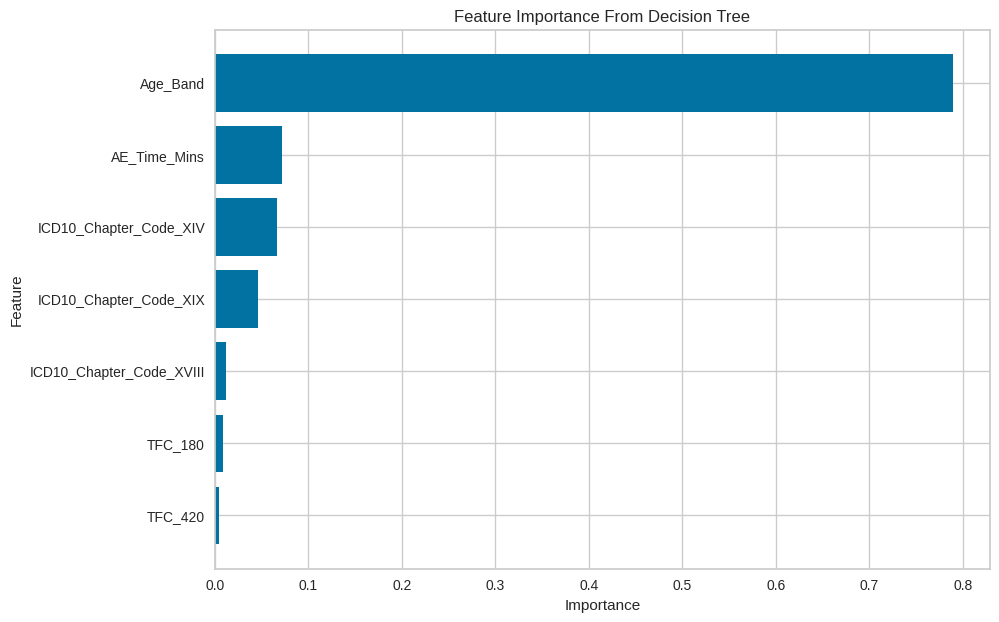

In [33]:
# Retrieve Feature Importance
importances = final_model.feature_importances_

# Match Feature Importance to Feature Names:
feature_names = [X_train.columns[i] for i in selected_feature_indices]

# Sort Features by Importance:
sorted_idx = np.argsort(importances)[::-1]

# Plot

plt.figure(figsize=(10, 7))
plt.barh(feature_names, importances[sorted_idx])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance From Decision Tree")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig(results_folder / "Feature_Importance.png", dpi=300)
plt.show()


In [34]:
# Create a DataFrame to hold feature names and their corresponding importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame based on the importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Save the DataFrame to a CSV file
feature_importance_df.to_csv(results_folder / 'Feature_Importance.csv', index=False)